# Loading the Data (Keep only the relevant columns)

In [36]:
import pandas as pd

# Path to the JSON file
file_path = r"C:\Users\pvX\LSTM_Seminar\yelp_dataset\yelp_academic_dataset_review.json"

# Read a sample of the dataset 
# only taking 1 million rows of data
df = pd.read_json(file_path, lines=True, nrows=1000000)

# Keep only the relevant columns
df = df[['text', 'stars']]
df


,text,stars
0,"If you decide to eat here, just be aware it is...",3
1,I've taken a lot of spin classes over the year...,5
2,Family diner. Had the buffet. Eclectic assortm...,3
3,"Wow! Yummy, different, delicious. Our favo...",5
4,Cute interior and owner (?) gave us tour of up...,4
...,...,...
999995,Never really had any issues here other than th...,3
999996,Fish recently moved a couple of doors down the...,4
999997,I've been to South House around a dozen or so ...,3
999998,Wow! I am shocked at these reviews. I have tri...,1


In [37]:
# Function to map star ratings to sentiment categories
def get_sentiment(stars):
    if stars == 5:
        return 'extremely positive'
    elif stars == 4:
        return 'positive'
    elif stars == 3:
        return 'neutral'
    elif stars == 2:
        return 'negative'
    elif stars == 1:
        return 'extremely negative'

# Apply the function to create a new column 'sentiment'
df['sentiment'] = df['stars'].apply(get_sentiment)

# Drop the 'stars' column as it is no longer needed
df = df.drop(columns=['stars'])

# Display the first few rows to check the new column
df


,text,sentiment
0,"If you decide to eat here, just be aware it is...",neutral
1,I've taken a lot of spin classes over the year...,extremely positive
2,Family diner. Had the buffet. Eclectic assortm...,neutral
3,"Wow! Yummy, different, delicious. Our favo...",extremely positive
4,Cute interior and owner (?) gave us tour of up...,positive
...,...,...
999995,Never really had any issues here other than th...,neutral
999996,Fish recently moved a couple of doors down the...,positive
999997,I've been to South House around a dozen or so ...,neutral
999998,Wow! I am shocked at these reviews. I have tri...,extremely negative


# Step 1: Preprocess the Text Data

In [38]:
import pandas as pd
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assuming df is your dataframe with 'text' and 'sentiment' columns

# Function to clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the text cleaning function
df['cleaned_text'] = df['text'].apply(clean_text)

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)  # Use the top 5000 words
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

# Pad the sequences to ensure uniform input length
max_sequence_length = 100  # Define a maximum sequence length
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Display the shape of the input data
print(X.shape)


(1000000, 100)


In [39]:
df

,text,sentiment,cleaned_text
0,"If you decide to eat here, just be aware it is...",neutral,you decide eat here just aware going take abou...
1,I've taken a lot of spin classes over the year...,extremely positive,taken lot spin classes over the years and noth...
2,Family diner. Had the buffet. Eclectic assortm...,neutral,family diner had the buffet eclectic assortmen...
3,"Wow! Yummy, different, delicious. Our favo...",extremely positive,wow yummy different delicious our favorite the...
4,Cute interior and owner (?) gave us tour of up...,positive,cute interior and owner gave tour upcoming pat...
...,...,...,...
999995,Never really had any issues here other than th...,neutral,never really had any issues here other than th...
999996,Fish recently moved a couple of doors down the...,positive,fish recently moved couple doors down the stre...
999997,I've been to South House around a dozen or so ...,neutral,been south house around dozen times and have h...
999998,Wow! I am shocked at these reviews. I have tri...,extremely negative,wow shocked these reviews have tried these cup...


# Step 2: Encode Sentiment Labels
Convert the sentiment labels to numerical values.

In [40]:
from sklearn.preprocessing import LabelEncoder

# Encode the sentiment labels
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(df['sentiment'])

# Display the encoded labels
print(y[:10])


[3 1 3 1 4 0 1 1 3 3]


# Step 3: Split the Data into Training and Testing Sets
Split the data into training and testing sets.

In [41]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(800000, 100) (200000, 100) (800000,) (200000,)


# Step 4: Build the LSTM Model
Build an LSTM model using Keras with early stopping.

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))  # Assuming 5 sentiment categories

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build the model with an input shape to ensure it is properly initialized
model.build(input_shape=(None, X.shape[1]))

# Display the model summary
model.summary()


C:\Users\pvX\anaconda3\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_8                  │ (None, 100, 128)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 100)                 │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 732,105 (2.79 MB)

 Trainable params: 732,105 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

# Step 5: Train the Model with Early Stopping
Train the LSTM model on the training data with early stopping.

In [43]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


Epoch 1/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1530s 122ms/step - accuracy: 0.6413 - loss: 0.8568 - val_accuracy: 0.6966 - val_loss: 0.7121
Epoch 2/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1650s 132ms/step - accuracy: 0.6992 - loss: 0.7066 - val_accuracy: 0.7036 - val_loss: 0.6935
Epoch 3/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1541s 123ms/step - accuracy: 0.7101 - loss: 0.6819 - val_accuracy: 0.7078 - val_loss: 0.6883
Epoch 4/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1506s 120ms/step - accuracy: 0.7156 - loss: 0.6683 - val_accuracy: 0.7096 - val_loss: 0.6824
Epoch 5/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1734s 139ms/step - accuracy: 0.7208 - loss: 0.6553 - val_accuracy: 0.7107 - val_loss: 0.6819
Epoch 6/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1877s 150ms/step - accuracy: 0.7234 - loss: 0.6482 - val_accuracy: 0.7115 - val_loss: 0.6785
Epoch 7/20
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 1811s 145ms/step - accuracy: 0.7271 - loss: 0.6410 - val_accuracy: 0.7113 - val_loss: 0.6805
Epoch 8/20
12500/12500 ━━━━━━━━━━━━━━━━━━

# Step 6: Evaluate the Model and Plot the Confusion Matrix
Evaluate the model on the test data and plot the confusion matrix.

6250/6250 - 149s - 24ms/step - accuracy: 0.7115 - loss: 0.6785
Test Accuracy: 0.71
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 162s 26ms/step
                    precision    recall  f1-score   support

extremely negative       0.76      0.86      0.81     27801
extremely positive       0.80      0.88      0.84     91722
          negative       0.50      0.38      0.44     15634
           neutral       0.54      0.43      0.48     20426
          positive       0.58      0.52      0.55     44417

          accuracy                           0.71    200000
         macro avg       0.64      0.61      0.62    200000
      weighted avg       0.70      0.71      0.70    200000



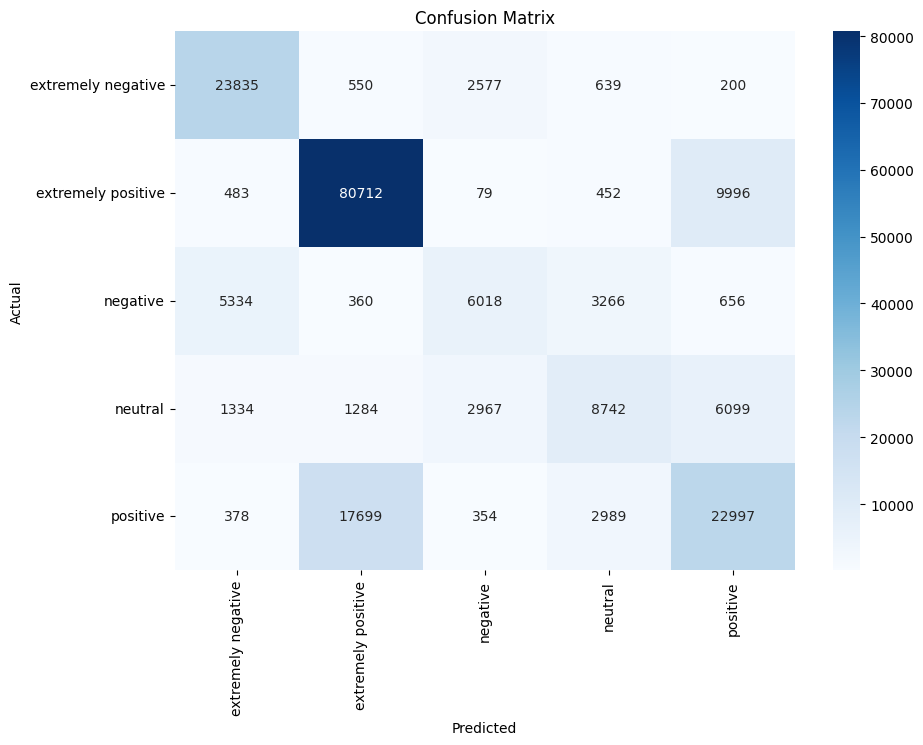

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Accuracy: {accuracy:.2f}')

# Generate predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)  # Update for TensorFlow 2.x
y_pred = label_encoder.inverse_transform(y_pred)
y_test_inv = label_encoder.inverse_transform(y_test)

# Print classification report
print(classification_report(y_test_inv, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test_inv, y_pred, labels=label_encoder.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Step 7: Save the Model
Save the trained model for future use.

In [45]:
# Save the model
model.save('sentiment_analysis_lstm_model.h5')

# Save the tokenizer and label encoder as well
import pickle

with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)


# Step 8: Visualize the Training Process
Visualize the training and validation accuracy and loss over epochs.

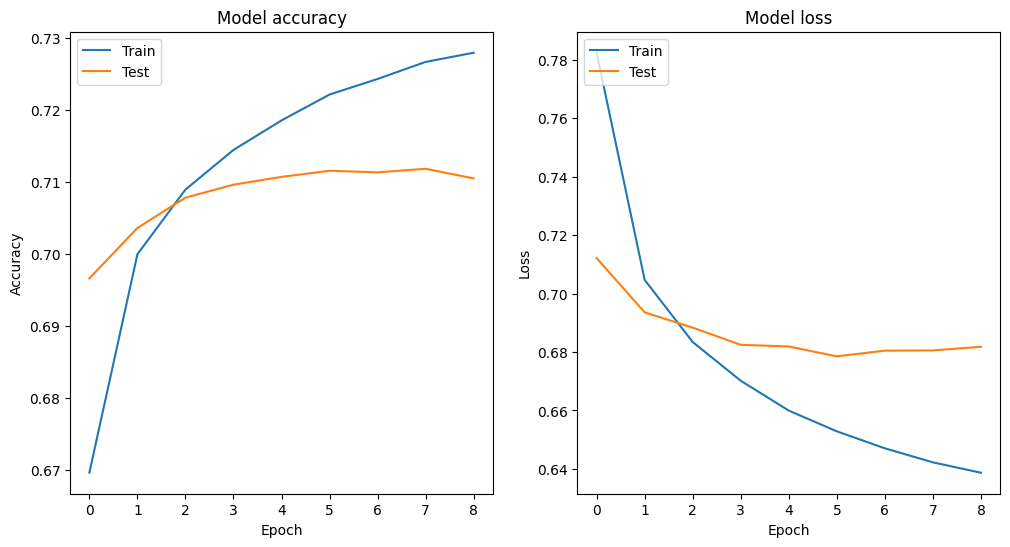

In [46]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
